## A Machine Learning approach to classifying $b$-matrices by cluster algebra: Keras

This notebook is to explore the application of machine learning algorithms to classifications of $b$-matrices in cluster algebras. This was inspired by the recent (2020) work of [1], where the authors take pairs of $b$-matrices and have their model decide if those pairs belong to the same cluster algebra or not. This is part of a new trend of applying machine learning to classification problems in algebra and physics [3,...,10]. Also notable for our work here is the paper [11] which uses these techniques to predict the cluster algebra from a seed.

Instead of the above approach, we frame the problem slightly differently. We will give our model a single $b$-matrix and ask it to predict which cluster algeba it belongs to. We first generate $2000$ $b$-matrices for each of the $A_5$ and $D_5$ cluster algebras. These are fed into various neural network models (written in Keras). We experiment with a set of hyperparameters until we are able to achieve an accuracy of around $0.75$. Since this is a binary classification, with a benchmark accuracy of $0.5$ (by simply guessing the cluster algebra at random), this is not particularly promissing. Possibly the number of training data is too low.

To try to fix this issues, we try to find more data. We use the $A_6$ and $D_6$ cluster algebras, with around $9000$ $b$-matrices from each. This approach gave us an accuracy of around $0.85$, which is fairly satisfying. 

Next we ask if our model can handle a ternary classification, so we introduce $9000$ $b$-matrices from the $E_6$ cluster algebra. Without changing the previous model, we are still able to achieve an accuracy of around $0.85$. It seems the introduction of an extra set of training data is enough to offset the difficulty of having a third possible target variable. It would be interesting to see how this model performs with the introduction of further cluster algebras.

The $b$-matrices mentioned above are generated in a supplementary worksheet running the Sage kernel, to make use of the Sage package for cluster algebras https://doc.sagemath.org/html/en/reference/algebras/sage/algebras/cluster_algebra.html. Interested readers may make use of the compendium for this package [2].

<cite data-cite="bao">[1] Bao, Jiakang, et al. "Quiver mutations, Seiberg duality, and machine learning." Physical Review D 102.8 (2020): 086013.</cite> https://arxiv.org/abs/2006.10783

<cite data-cite="musiker">[2] Musiker, Gregg, and Christian Stump. "A compendium on the cluster algebra and quiver package in Sage." arXiv preprint arXiv:1102.4844 (2011). </cite> https://arxiv.org/abs/1102.4844

<cite data-cite="betzler">[3] Betzler, Philip, and Sven Krippendorf. "Connecting dualities and machine learning." Fortschritte der Physik 68.5 (2020): 2000022.
    
<cite data-cite="krippendorf">[4] Krippendorf, Sven, and Marc Syvaeri. "Detecting symmetries with neural networks." Machine Learning: Science and Technology 2.1 (2020): 015010.
    
<cite data-cite="he2">[5] He, Yang-Hui. "Machine-learning the string landscape." Physics Letters B 774 (2017): 564-568.   
    
<cite data-cite="krefl">[6] Krefl, Daniel, and Rak-Kyeong Seong. "Machine learning of Calabi-Yau volumes." Physical Review D 96.6 (2017): 066014.
    
<cite data-cite="ruehle">[7] Ruehle, Fabian. "Evolving neural networks with genetic algorithms to study the String Landscape." Journal of High Energy Physics 2017.8 (2017): 1-20.
    
<cite data-cite="carifio">[8] Carifio, Jonathan, et al. "Machine learning in the string landscape." Journal of High Energy Physics 2017.9 (2017): 1-36
    
<cite data-cite="betzler">[9] Betzler, Philip, and Sven Krippendorf. "Connecting dualities and machine learning." Fortschritte der Physik 68.5 (2020): 2000022
    
<cite data-cite="krippendorf">[10] Krippendorf, Sven, and Marc Syvaeri. "Detecting symmetries with neural networks." Machine Learning: Science and Technology 2.1 (2020): 015010.
    
<cite data-cite="dechant">[11] Dechant, Pierre-Philippe, et al. "Cluster Algebras: Network Science and Machine Learning." arXiv preprint arXiv:2203.13847 (2022).

## Contents:
* [Importing the data](#first)
* [A simple Keras model for $A_5$ and $D_5$](#second)
* [A more complicated Keras model for $A_5$ and $D_5$ and experiments with hyperparameters](#third)
* [Trying our model with $A_6$ and $D_6$](#fourth)
* [Ternary classification with $A_6$, $D_6$ and $E_6$](#fifth)

## Importing the data <a class="anchor" id="first"></a>

In [1]:
import numpy as np
import csv
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation

In [21]:
with open('cluster_data_A5_depth_100.csv') as fp:
    reader = csv.reader(fp, delimiter=",", quotechar='"')
    data = [row for row in reader]
    
data=data[0] # All stored in first row, so just take that

cluster_type = data[0] # Cluster type stored as first entry

data = [np.array(np.matrix(data[i])).ravel() for i in range(1, len(data))] # The vectors have been converted to strings,
                                                                           # so need to undo this. Also discard cluster type
data = [np.append(i, np.array([1, 0])) for i in data]
A5_data = data

In [22]:
# We want this as a single array, not a list of arrays.

A_array = A5_data[0]
for i in range(1, len(A5_data)):
    A_array = np.vstack([A_array, A5_data[i]])

In [23]:
# Now we do the same for D type

with open('cluster_data_D5_depth_100.csv') as fp:
    reader = csv.reader(fp, delimiter=",", quotechar='"')
    data = [row for row in reader]    
data=data[0]
cluster_type = data[0]
data = [np.array(np.matrix(data[i])).ravel() for i in range(1, len(data))]
data = [np.append(i, np.array([0, 1])) for i in data]
D5_data = data

D_array = D5_data[0]
for i in range(1, len(D5_data)):
    D_array = np.vstack([D_array, D5_data[i]])

In [24]:
# The features X are the matrices
X = np.vstack([A_array[:,:-2], D_array[:,:-2]])

In [25]:
# The target variables are the cluster types, here we encode A5 as [1,0] and D5 as [0,1]
y = np.vstack([A_array[:,-2:], D_array[:,-2:]])

In [26]:
# Train / test split. This shuffles by default 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11)

## A simple Keras model for $A_5$ and $D_5$ <a class="anchor" id="second"></a>

We use a simple sequential neural network with $25$ input nodes, one dense layer with $64$ nodes and an finally $2$ output nodes. If we use a small batch size or large number of epochs we can obtain accuracies approaching $0.7$. This isn't very useful so far.

In [78]:
model = Sequential([
    Dense(64, input_dim=25), 
    Activation("relu"),
    Dense(2), 
    Activation("relu")
])

# Smaller batch sizes seems to work better (tested as low as 5). We will change this while we experiment.
batch_size = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

# A good learning rate seems to be 0.001.
model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"],
)

# Small number of epochs is faster, but we should increase this for better results. We will use a large number for our plots.
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=300, validation_split=0.2, verbose=False, callbacks=[callback])
test_scores = model.evaluate(X_test, y_test, verbose=2)

43/43 - 0s - loss: 1.0386 - accuracy: 0.6349 - 50ms/epoch - 1ms/step


We can plot the accuracy and loss for the train and validate data. The accuracy seems to be still increasing up to epoch 200. The train and validate curves seem to track each other, which suggests we aren't overfitting.

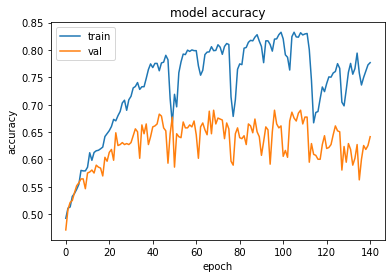

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

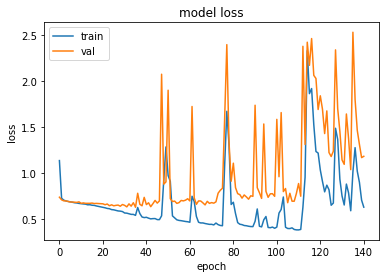

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## A more complicated Keras model for $A_5$ and $D_5$ and experiments with hyperparameters <a class="anchor" id="third"></a>

Let's try a more complicated Keras model. We can only obtain an accuracy of around $0.66$. Our plots suggest overfitting, since we are obtaining very good results for the training data. We have increased the batch size here for better performance.

In [90]:
model = Sequential([
    Dense(64, input_dim=25), 
    Activation("relu"), 
    Dense(64), 
    Activation("relu"), 
    Dense(2), 
    Activation("relu"), 
])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"],
)
history = model.fit(X_train, y_train, batch_size=30, epochs=300, validation_split=0.2, verbose=False, callbacks=[callback])
test_scores = model.evaluate(X_test, y_test, verbose=2)

43/43 - 0s - loss: 1.0423 - accuracy: 0.6604 - 54ms/epoch - 1ms/step


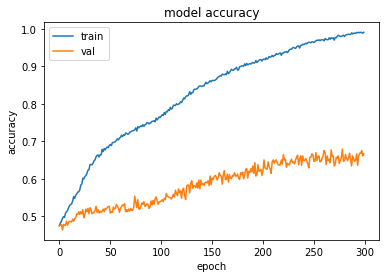

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We want to experiment with our hyperparameters to see if we can make this model useful. Here we change the number of nodes in the dense layers to $230$ which seems to work well. Using the low batch size above $(30)$ causes the learning to get stuck. Using a batch size of $100$ gives good results, sometimes close to $0.8$.

In [99]:
model = Sequential([
    Dense(230, input_dim=25), 
    Activation("relu"), 
    Dense(230), 
    Activation("relu"), 
    Dense(2), 
    Activation("relu"), 
])

batch_size = 100

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"],
)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=300, validation_split=0.2, verbose=False, callbacks=[callback])
test_scores = model.evaluate(X_test, y_test, verbose=2)

43/43 - 0s - loss: 0.9390 - accuracy: 0.7280 - 50ms/epoch - 1ms/step


We now experiment with different activation functions. Here having the first and last functions as exponential linear seems to work well, while it is better for the middle function to remain as rectified linear.

In [101]:
model = Sequential([
    Dense(230, input_dim=25), 
    Activation("elu"),
    Dense(230), 
    Activation("relu"), 
    Dense(2), 
    Activation("elu"),
])

batch_size = 100

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"],
    )
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=300, validation_split=0.2, verbose=False, callbacks=[callback])
test_scores = model.evaluate(X_test, y_test, verbose=2)

43/43 - 0s - loss: 0.5100 - accuracy: 0.7869 - 89ms/epoch - 2ms/step


We now experiment with optimizers. RMSprop seems to perform the best here. This is our final model, as the choice of loss function seems to make little difference.

In [102]:
model = Sequential([
    Dense(230, input_dim=25), 
    Activation("elu"), 
    Dense(230), 
    Activation("relu"), 
    Dense(2), 
    Activation("elu"), 
    Activation("softmax")
])

batch_size = 100

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = keras.optimizers.RMSprop(0.001),
    metrics = ["accuracy"],
    )
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=300, validation_split=0.2, verbose=False, callbacks=[callback])
test_scores = model.evaluate(X_test, y_test, verbose=2)

43/43 - 0s - loss: 0.6118 - accuracy: 0.8051 - 68ms/epoch - 2ms/step


We plot the final accuracy graph. It seems reasonable that the performance of our model is hampered by the size of the training data.

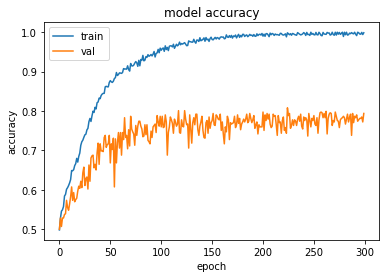

In [103]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Trying our model with $A_6$ and $D_6$ <a class="anchor" id="fourth"></a>

Let's import some $b$-matrices for $A_6$ and $D_6$. We will have around $9000$ matrices for each.

In [104]:
with open('cluster_data_A6_depth_6.csv') as fp:
    reader = csv.reader(fp, delimiter=",", quotechar='"')
    data = [row for row in reader]
    
data=data[0]

cluster_type = data[0]

data = [np.array(np.matrix(data[i])).ravel() for i in range(1, len(data))]
                                                                           
data = [np.append(i, np.array([1, 0])) for i in data]
A6_data = data
A_array = A6_data[0]
for i in range(1, len(A6_data)):
    A_array = np.vstack([A_array, A6_data[i]])
    

with open('cluster_data_D6_depth_6.csv') as fp:
    reader = csv.reader(fp, delimiter=",", quotechar='"')
    data = [row for row in reader]
    
data=data[0]

cluster_type = data[0]

data = [np.array(np.matrix(data[i])).ravel() for i in range(1, len(data))]
                                                                           
data = [np.append(i, np.array([0, 1])) for i in data]
D6_data = data
D_array = D6_data[0]
for i in range(1, len(D6_data)):
    D_array = np.vstack([D_array, D6_data[i]])

In [105]:
# Features, targets
X = np.vstack([A_array[:,:-2], D_array[:,:-2]])

y = np.vstack([A_array[:,-2:], D_array[:,-2:]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11)

Let's try our model on this new data to check the performance. We obtain a respectable accuracy of $0.87$.

In [107]:
model = Sequential([
    Dense(230, input_dim=36), 
    Activation("elu"), 
    Dense(230), 
    Activation("relu"), 
    Dense(2), 
    Activation("elu"),
])

batch_size = 100

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = keras.optimizers.RMSprop(0.001),
    metrics = ["accuracy"],
)

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=300, validation_split=0.2, verbose=False, callbacks=[callback])
test_scores = model.evaluate(X_test, y_test, verbose=2)

193/193 - 0s - loss: 0.5364 - accuracy: 0.8709 - 254ms/epoch - 1ms/step


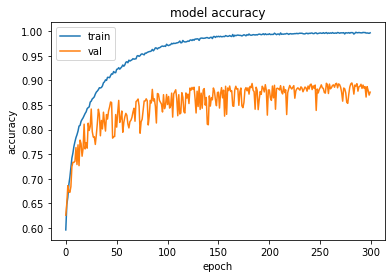

In [108]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Ternary classification with $A_6$, $D_6$ and $E_6$ <a class="anchor" id="fifth"></a>

Let's introduce $b$-matrices of $E_6$ type to see how our model can handle a ternary classification.

In [109]:
with open('cluster_data_A6_depth_6.csv') as fp:
    reader = csv.reader(fp, delimiter=",", quotechar='"')
    data = [row for row in reader]
    
data=data[0]

cluster_type = data[0]

data = [np.array(np.matrix(data[i])).ravel() for i in range(1, len(data))]
                                                                           
data = [np.append(i, np.array([1, 0, 0])) for i in data] # Now we have 3 labels need to relabel targets as 3-d basis vectors
A6_data = data
A_array = A6_data[0]
for i in range(1, len(A6_data)):
    A_array = np.vstack([A_array, A6_data[i]])
    

with open('cluster_data_D6_depth_6.csv') as fp:
    reader = csv.reader(fp, delimiter=",", quotechar='"')
    data = [row for row in reader]
    
data=data[0]

cluster_type = data[0]

data = [np.array(np.matrix(data[i])).ravel() for i in range(1, len(data))]
                                                                           
data = [np.append(i, np.array([0, 1, 0])) for i in data]
D6_data = data
D_array = D6_data[0]
for i in range(1, len(D6_data)):
    D_array = np.vstack([D_array, D6_data[i]])
    
with open('cluster_data_E6_depth_6.csv') as fp:
    reader = csv.reader(fp, delimiter=",", quotechar='"')
    data = [row for row in reader]
    
data=data[0]

cluster_type = data[0]

data = [np.array(np.matrix(data[i])).ravel() for i in range(1, len(data))]
                                                                           
data = [np.append(i, np.array([0, 0, 1])) for i in data]
E6_data = data
E_array = E6_data[0]
for i in range(1, len(E6_data)):
    E_array = np.vstack([E_array, E6_data[i]])

In [111]:
# Features, targets
X = np.vstack([A_array[:,:-3], D_array[:,:-3]])

y = np.vstack([A_array[:,-3:], D_array[:,-3:]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11)

Now we run our model. Our accuracy is at $0.87$, which is good considering that this problem is more difficult than the binary version.

In [112]:
model = Sequential([
    Dense(230, input_dim=36), 
    Activation("elu"), 
    Dense(230), 
    Activation("relu"), 
    Dense(3), 
    Activation("elu"), 
    Activation("softmax")
])

batch_size = 100

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = keras.optimizers.RMSprop(0.001),
    metrics = ["accuracy"],
)

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=300, validation_split=0.2, verbose=False, callbacks=[callback])
test_scores = model.evaluate(X_test, y_test, verbose=2)

193/193 - 0s - loss: 0.4764 - accuracy: 0.8704 - 254ms/epoch - 1ms/step


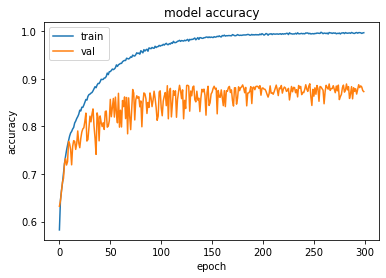

In [113]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In summary, with the proper choice of hyperparameters we can obtain fairly respectable accuracies for classifying $b$-matrices by cluster algebra, both for binary and ternary classifications.

There are many more cluster algebras we could have introduced to this problem, as well as many more models we could have tried. In particular the authors of [1] obtain good results for binary classifications using a Naive Bayes classification in sklearn. This is an area for further exploration.